**Paper implementation**: [SMOTE(Chawla et al. 2020)](https://arxiv.org/abs/1106.1813)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB

In [3]:
from imblearn.over_sampling import SMOTE

# SMOTE: codes

In [4]:
class smote:
    def __init__(self, k_neighbors=5, random_state=None):
        self.k_neighbors = k_neighbors
        self.random_state = random_state
    
    # Get the indices of the k(=k_neighbors) nearest neighbors of the idx-th row in the given array
    def _get_nearest(self, array, idx, ):
        dist = []
        for row in range(array.shape[0]):
            # L2 distance between two samples
            norm = np.linalg.norm( array[idx] - array[row] )
            dist.append(norm)
        dist = np.array(dist)
        result = dist.argsort()[:self.k_neighbors+1]
        return result[result!=idx]
    
    # Generate the synthetic samples for each minority class sample and stack them
    def _populate(self, n, i, nnarr, ):
        np.random.seed(self.random_state + i)
        nn = np.random.randint(0, self.k_neighbors, n)
        Gap = np.random.random(n)
        for e in range(n):
            dif = self.sample[nnarr[nn[e]], :] - self.sample[i, :]
            gap = np.tile(Gap[e], self.numattrs)
            self.synthetic = np.vstack((self.synthetic, self.sample[i, :] + dif * gap))
            
        # Based on the origin pseudocode of paper
        '''while n!=0:
            nn = np.random.randint(1, self.k_neighbors)
            
            dif = self.sample[nnarr[nn], :] - self.sample[i, :]
            gap = np.tile(np.random.random(1)[0], self.numattrs)
            self.synthetic = np.vstack((self.synthetic, self.sample[i, :] + dif * gap))
            n -= 1'''
    
    # Fit the SMOTE instance with an imbalanced dataset
    def fit(self, X, y, return_synthetic = False):
        y = y.flatten()
        cls_major = np.unique(y, return_counts=True)[0][0]
        cls_minor = np.unique(y, return_counts=True)[0][1]
        num_major = max(np.unique(y, return_counts=True)[1])
        num_minor = min(np.unique(y, return_counts=True)[1])
        
        # sample: Minority class samples
        # N: the number of synthetic samples generated for each minority class sample
        # numattrs: the number of columns i.e. features
        # synthetic: an empty array in which the generated synthetic samples will be stacked
        
        self.sample = X[np.where(y==cls_minor)[0]]
        self.N = int(num_major / num_minor) - 1
        self.numattrs = X.shape[1]
        self.synthetic = np.array([]).reshape(-1, self.numattrs)
        
        for ind in range(self.sample.shape[0]):
            nnarray = self._get_nearest(array = self.sample, idx= ind)
            self._populate(self.N, ind, nnarray)
        
        self.synthetic_y = np.tile(cls_minor, self.synthetic.shape[0])
        
        if return_synthetic == True:
            return self.synthetic, self.synthetic_y
        else:
            pass
    
    # Get the synthetic features and label only
    def get_symthetic(self):
        try:
            return self.synthetic, self.synthetic_y
        except: raise AttributeError('Please fit first.') from None
    
    # Resample the dataset.
    def resample(self, X, y):
        try:
            resample = np.hstack((np.vstack((X, self.synthetic)), np.append(y, self.synthetic_y).reshape(-1, 1) ))
            np.random.shuffle(resample)
            return resample[:, :-1], resample[:, -1]
        # Raise AttributeError if dataset were not fitted. 
        except: raise AttributeError('Please fit first.') from None

In [5]:
data = make_classification(n_features=4, n_samples=1000, weights=[0.9], random_state= 42, )
#data = make_classification(n_features=2, n_informative=2,n_redundant=0,n_samples=1000, n_clusters_per_class=2, weights=[0.9], random_state= 42, )

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data[0], data[1], test_size = .2, random_state=42,)

In [208]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [209]:
model_rf = RandomForestClassifier(n_estimators=100,random_state=42)
model_rf.fit(X_train, y_train)
pred_rf = model_rf.predict(X_test)

print('Accuracy:', model_rf.score(X_test, y_test))
print('Precision score:', precision_score(y_test, pred_rf))
print('Recall score:', recall_score(y_test, pred_rf))
print('F1 score:', f1_score(y_test, pred_rf))
print('AUC:', roc_auc_score(y_test, model_rf.predict_proba(X_test)[:, 1] ))

Accuracy: 0.955
Precision score: 1.0
Recall score: 0.64
F1 score: 0.7804878048780487
AUC: 0.9488


In [210]:
X_samp, y_samp = SMOTE(k_neighbors=5, random_state=42).fit_resample(X_train, y_train)


model_rf = RandomForestClassifier(n_estimators=100,random_state=42)
model_rf.fit(X_samp, y_samp)
pred_rf = model_rf.predict(X_test)

print('Accuracy:', model_rf.score(X_test, y_test))
print('Precision score:', precision_score(y_test, pred_rf))
print('Recall score:', recall_score(y_test, pred_rf))
print('F1 score:', f1_score(y_test, pred_rf))
print('AUC:', roc_auc_score(y_test, model_rf.predict_proba(X_test)[:, 1] ))

Accuracy: 0.955
Precision score: 0.8333333333333334
Recall score: 0.8
F1 score: 0.816326530612245
AUC: 0.9438857142857142


In [15]:
sm = smote(k_neighbors=5, random_state=42)
sm.fit(X_train, y_train)
X_samp, y_samp = sm.resample(X_train, y_train)

model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_samp, y_samp)
pred_rf = model_rf.predict(X_test)

print('Accuracy:', model_rf.score(X_test, y_test))
print('Precision score:', precision_score(y_test, pred_rf))
print('Recall score:', recall_score(y_test, pred_rf))
print('F1 score:', f1_score(y_test, pred_rf))
print('AUC:', roc_auc_score(y_test, model_rf.predict_proba(X_test)[:, 1] ))

Accuracy: 0.96
Precision score: 0.8695652173913043
Recall score: 0.8
F1 score: 0.8333333333333333
AUC: 0.9629714285714286


# Visualization

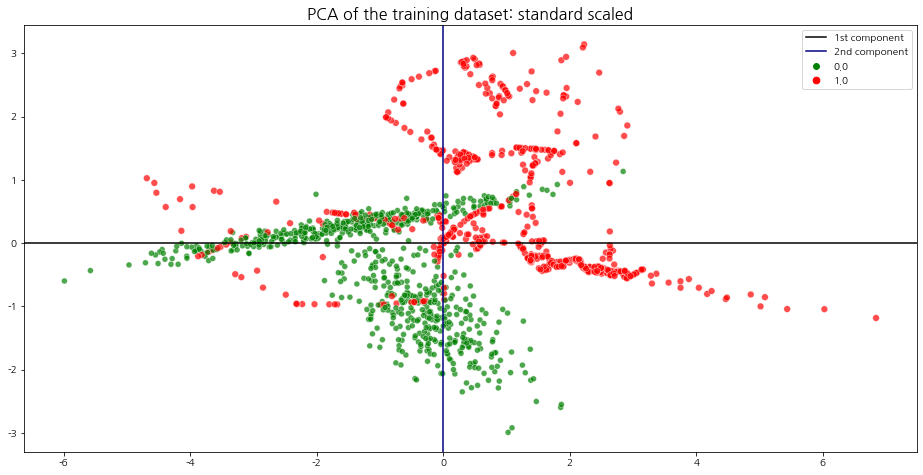

In [31]:
pca = PCA(n_components=2, random_state=42)

scaler = StandardScaler()
xpca = pca.fit_transform(scaler.fit_transform(X_samp))

fig, ax = plt.subplots(1,1, figsize = (16,12))
ax.set_aspect(1)
ax.axline((.0, .0), (pca.transform(pca.components_)[0,0], pca.transform(pca.components_)[0,1]), c='k', label='1st component')
ax.axline((.0, .0), (pca.transform(pca.components_)[1,0], pca.transform(pca.components_)[1,1]), c='navy', label='2nd component')
sns.scatterplot(x = xpca[:,0], y=xpca[:,1], hue=y_samp,  alpha=.7, palette={.0:'green', 1.:'red'}, size = y_samp, sizes={.0:35, 1.:45} )
plt.title('PCA of the training dataset: standard scaled', fontsize = 16)
plt.show()

In [28]:
X_syn, y_syn = sm.get_symthetic()

In [29]:
X_df = pd.DataFrame(np.vstack((X_train, X_syn)), columns = ['col_{}'.format(str(i).zfill(2)) for i in range(data[0].shape[1])])
X_df['class'] = ['train: {}'.format(i) for i in y_train.tolist()] + ['train: 1(SMOTE)']*len(y_syn)

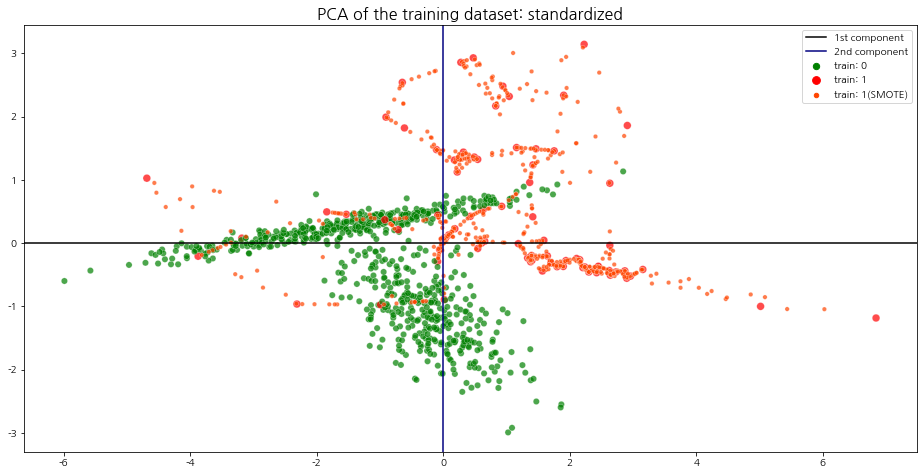

In [30]:
pca = PCA(n_components=2, random_state=42)

scaler = StandardScaler()
xpca = pca.fit_transform(scaler.fit_transform(X_df.values[:, :-1]))

fig, ax = plt.subplots(1,1, figsize = (16,12))
ax.set_aspect(1)
ax.axline((.0, .0), (pca.transform(pca.components_)[0,0], pca.transform(pca.components_)[0,1]), c='k', label='1st component')
ax.axline((.0, .0), (pca.transform(pca.components_)[1,0], pca.transform(pca.components_)[1,1]), c='navy', label='2nd component')
sns.scatterplot(x = xpca[:,0], y=xpca[:,1], hue=X_df.values[:, -1], palette={'train: 0':'green', 'train: 1':'red', 'train: 1(SMOTE)':'orangered'}, size=X_df.values[:, -1], 
                sizes={'train: 0':40, 'train: 1':60, 'train: 1(SMOTE)':20}, alpha=.7 )
plt.title('PCA of the training dataset: standardized', fontsize = 16)
plt.show()

In [32]:
num_linspace = .02
ll = [np.arange(xpca.min(axis=0)[col] -.2 , xpca.max(axis=0)[col] +.2 ,num_linspace) for col in range(xpca.shape[1]) ]

In [33]:
xx, yy, = np.meshgrid(*ll)

In [34]:
if X_df.shape[1]<=3:
    Z = model_rf.predict_proba(np.c_[xx.ravel(), yy.ravel(),])[:, 1 ]
else:
    Z = model_rf.predict_proba(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel(),]))[:, 1 ]

In [35]:
cm = plt.cm.RdBu_r

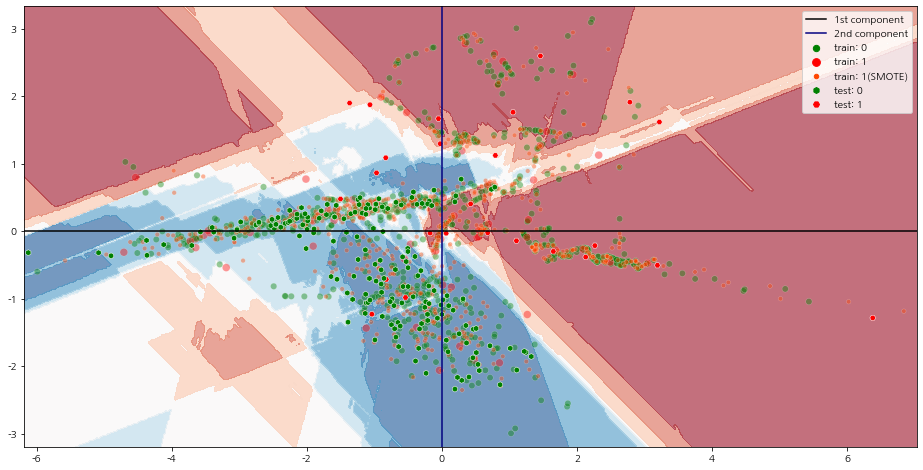

In [36]:
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots(1,1, figsize = (16,12))
ax.set_aspect(1)

ax.axline((.0, .0), (pca.transform(pca.components_)[0,0], pca.transform(pca.components_)[0,1]), c='k', label='1st component')
ax.axline((.0, .0), (pca.transform(pca.components_)[1,0], pca.transform(pca.components_)[1,1]), c='navy', label='2nd component')

# Plot filled contours
plt.contourf(xx, yy, Z, cmap=cm, alpha=.6)

# Plot the training points
sns.scatterplot(x = xpca[:,0], y=xpca[:,1], hue=X_df.values[:, -1], palette={'train: 0':'green', 'train: 1':'red', 'train: 1(SMOTE)':'orangered'}, size=X_df.values[:, -1],
                hue_order = ['train: 0', 'train: 1', 'train: 1(SMOTE)'], sizes = {'train: 0':40, 'train: 1':60, 'train: 1(SMOTE)':20}, alpha = .4 )

# Plot the testing points
if data[0].shape[1]<=2:
    sns.scatterplot(x = (X_test)[:, 0], y = (X_test)[:, 1], hue = y_test, palette={0:'green', 1:'red'}, style=y_test, markers={0:'*', 1:'v'}, )
else:
    y_test_str = np.vectorize(lambda x: 'test: 1' if x==1 else 'test: 0')(y_test)
    sns.scatterplot(x = pca.transform(scaler.transform(X_test))[:, 0], y = pca.transform(scaler.transform(X_test))[:, 1], hue = y_test_str, hue_order = ['test: 0', 'test: 1'],
                     palette={'test: 0':'green', 'test: 1':'red'}, style = y_test_str, markers={'test: 0':'h', 'test: 1':'H'},  alpha=1.  )
plt.legend()
plt.show()